<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Module-version-used" data-toc-modified-id="Module-version-used-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Module version used</a></span></li><li><span><a href="#Import-modules" data-toc-modified-id="Import-modules-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import modules</a></span></li><li><span><a href="#Generate-a-toy-dataset" data-toc-modified-id="Generate-a-toy-dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generate a toy dataset</a></span></li><li><span><a href="#Preparing-a-toy-dataset" data-toc-modified-id="Preparing-a-toy-dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Preparing a toy dataset</a></span></li><li><span><a href="#Defining-the-Perceptron-model" data-toc-modified-id="Defining-the-Perceptron-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Defining the Perceptron model</a></span></li><li><span><a href="#Training-the-Perceptron" data-toc-modified-id="Training-the-Perceptron-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Training the Perceptron</a></span></li><li><span><a href="#Evaluating-the-model" data-toc-modified-id="Evaluating-the-model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Evaluating the model</a></span></li></ul></div>

## Module version used

- torch 1.4.0
- numpy 1.18.1
- CPython 3.6.10
- IPython 7.12.0

## Import modules

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

## Generate a toy dataset

In [48]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
import numpy as np
import math

# centers of the blobs
centers = [(-0.5,-0.5),(2,2)]
Variances = [1.0,1.0]
stdDev = [math.sqrt(i) for i in Variances]
    
X,y = make_blobs(n_samples=100, n_features=2, centers=centers,cluster_std=stdDev,
                  random_state=0)
y = y
all_projdata = np.concatenate((X,np.reshape(y,(100,1))), axis=1)
np.savetxt("data/Perceptron_data.txt", all_projdata, fmt='%.4e', delimiter=' ') 

## Preparing a toy dataset

In [49]:
data = np.genfromtxt('data/Perceptron_data.txt', delimiter=' ')
X, y = data[:, :2], data[:, 2]
y = y.astype(np.int)

print('Class label counts:', np.bincount(y))
print('X.shape:', X.shape)
print('y.shape:', y.shape)

# Shuffling & train/test split
shuffle_idx = np.arange(y.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)
X, y = X[shuffle_idx], y[shuffle_idx]

X_train, X_test = X[shuffle_idx[:70]], X[shuffle_idx[70:]]
y_train, y_test = y[shuffle_idx[:70]], y[shuffle_idx[70:]]

# Normalize (mean zero, unit variance)
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

Class label counts: [50 50]
X.shape: (100, 2)
y.shape: (100,)


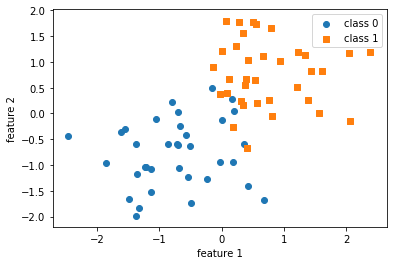

In [50]:
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend()
plt.show()

## Defining the Perceptron model

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def custom_where(cond, x_1, x_2):
    return (cond * x_1) + ((~cond) * x_2)


class Perceptron():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, 
                                   dtype=torch.float32, device=device)
        self.bias = torch.zeros(1, dtype=torch.float32, device=device)

    def forward(self, x):
        linear = torch.add(torch.mm(x, self.weights), self.bias)   # y = xw+b
        predictions = custom_where(linear > 0., 1, 0).float()
        return predictions
        
    def backward(self, x, y):  
        predictions = self.forward(x)
        errors = y - predictions
        return errors
        
    def train(self, x, y, epochs):
        for e in range(epochs):
            
            for i in range(y.size()[0]):
                # use view because backward expects a matrix (i.e., 2D tensor)
                errors = self.backward(x[i].view(1, self.num_features), y[i]).view(-1)
                self.weights += (errors * x[i]).view(self.num_features, 1)
                self.bias += errors
                
    def evaluate(self, x, y):
        predictions = self.forward(x).view(-1)
        accuracy = torch.sum(predictions == y).float() / y.size()[0]
        return accuracy

## Training the Perceptron

In [53]:
ppn = Perceptron(num_features=2)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

ppn.train(X_train_tensor, y_train_tensor, epochs=5)

print('Model parameters:')
print('  Weights: %s' % ppn.weights)
print('  Bias: %s' % ppn.bias)

Model parameters:
  Weights: tensor([[2.3582],
        [2.2001]])
  Bias: tensor([0.])


## Evaluating the model

In [54]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

test_acc = ppn.evaluate(X_test_tensor, y_test_tensor)
print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 100.00%


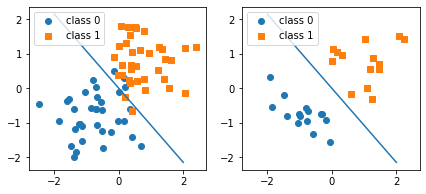

In [56]:
##########################
### 2D Decision Boundary
##########################

w, b = ppn.weights, ppn.bias

x_min = -2
y_min = ( (-(w[0] * x_min) - b[0]) 
          / w[1] )

x_max = 2
y_max = ( (-(w[0] * x_max) - b[0]) 
          / w[1] )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
plt.show()

In [57]:
%watermark -iv

torch 1.4.0
numpy 1.18.1

